### 锚框
> * 一类目标检测算法是基于锚框的
>> * 提出多个被称为锚框的区域（边缘框）
>> * 预测每个锚框里是否含有关注的物体
>> * 如果是，预测从这个锚框到真实边缘框的偏移

### IoU-交并比
> * IoU用来计算两个框之间的相似度
>> * 0表示重叠，1表示重合
> * 这是Jacquard指数的一个特殊情况
>> * 给定两个集合A和B
>> * $J(A,B)=\frac{|A\cap B|}{|A\cup B|}$

![](../images/IoU.png)

### 赋予锚框标号
> * 每个锚框是一个训练样本
> * 将每个锚框， 要么标注为背景， 要么关联上一个真实边缘框
> * 我们会生成大量的锚框
>> * 这会导致大量的负类样本

### 使用非极大值抑制（NMS）输出
> * 每个锚选预测一个边缘框
> * NMS可以合并相似的预测
>> * 选中非背景类的最大预测值
>> * 去掉所有其它和它IoU值大于$\theta$的预测
>> * 重复上述过程直到所有预测要么被选中， 要么被去掉

### 总结
> * 一类目标检测算法基于锚框来预测
>> * 首先生成大量锚框，并赋予标号， 每个锚框作为一个样本进行训练
>> * 在预测时，使用NMS来去掉冗余的预测

In [1]:
%matplotlib inline
import torch
from d2l import limutorch as d2l

torch.set_printoptions(2)

锚框的宽度和高度分别是$ws\sqrt{r}$和$\frac{hs}{\sqrt r}$,这里的h并不是图像高度，实际以下例为准
上述s是缩放比($\frac{wh}{WH}=s^2$，其中wh是缩放后图像宽高，WH是真实图像宽高)，r为宽高比($\frac{w}{h}=r$),由此可得$w=s\sqrt{HWr},h=s\sqrt{\frac{HW}{r}}$。
当设置许多缩放比取值$s_1,s_2,...,s_n$和许多宽高比取值$r_1,r_2,r_3,...,r_m$时，以每个像素为中心，会得到$whmn$个锚框，<font color='red'>尽管这些锚框可能覆盖真实锚框，但计算复杂性很容易过高，所以在实践中只考虑包含$s_1$或者$r_1$的组合：$(s_1,r_1),(s_2, r_2),...,(s_2,r_m),(s_2,r_1),(s_3,r_3),...,(s_n,r_1)$，也就是说，对于同一像素为中心的锚框数量为$n+m-1$，整张图像共生成锚框$wh(n+m-1)$个</font>

In [31]:
def multibox_prior(data, sizes, ratios):
    """生成以每个像素为中心具有不同形状的锚框"""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    """为了将锚点移动到像素中心，需要设置偏移量"""
    """因为像素的高和宽为1，所以设置偏移量为0.5"""
    offset_h, offset_w = 0.5, 0.5
    step_h = 1.0 / in_height ## 在y轴上缩放步长
    step_w = 1.0 / in_width ## 在x轴上缩放步长

    """生成锚框的所有中心点"""
    center_h = (torch.arange(in_height, device=device) + offset_h) * step_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * step_w
    #print("center_h:")
    #print(center_h)
    #print("center_w:")
    #print(center_w)
    ## torch.meshgrid()的功能生成网格，可以用以生成坐标。函数输入两个数据类型相同的一维张量，两个输出张量的行数为第一个输入张量的元素个数，列数为第二个输入张量的元素个数，当两个输入张量数据类型不同或者维度不是一维时报错
    ## 其中第一个输出张量填充第一个输入张量中的元素，各行元素相同，第二个输出张量填充第二个输入张量中的元素各列元素相同
    """例如 ：
        输入a[1, 2, 3], b[4, 5, 6, 7]
        经过方法meshgrid()后输出：
        x[[1, 1, 1, 1],
          [2, 2, 2, 2],
          [3, 3, 3, 3]],
        y[[4, 5, 6, 7],
          [4, 5, 6, 7],
          [4, 5, 6, 7]]
    """
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    #print("shift_y:")
    #print(shift_y)
    #print("shift_x:")
    #print(shift_x)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    #print(shift_y.shape, shift_x.shape)

    """生成boxes_per_pixel个宽和高"""
    """之后用于创建锚框的四角坐标（xmin，ymin，xmax，yamx）"""
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height / in_width ## 处理矩形输入
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))

    #print("w:")
    #print(w)
    #print("h:")
    #print(h)

    """除以2来获得半高和半宽，除以2获取半宽和半高，可以通过加减中心坐标获取锚框的左上和右下坐标"""
    ## torch.repeat()元素进行重复
    """假设输入为
    a[[1, 2, 3],
      [4, 5, 6]]
      a的大小为2*3，那么经过torch.repeat(2, 2, 1)会变成2*4*3,repeat中的数字代表扩张几倍
      输出为：
      [[[1, 2, 3],
        [4, 5, 6],
        [1, 2, 3],
        [4, 5, 6]],
       [[1, 2, 3],
        [4, 5, 6],
        [1, 2, 3],
        [4, 5, 6]]]
    """
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2

    """每个中心点都将有boxes_per_pixel个锚框"""
    """所以生成含所有锚框中心的网络，重复了boxes_per_pixel"""
    #print("anchor_manipulations:")
    #print(anchor_manipulations)
    ## torch.repeat_interleave()也是对元素进行扩张,默认情况下会将张量铺开进行重复，也可以指定维度
    """例如输出
    a[[1, 2],
      [3, 4]]
      经过torch.repeat_interleave(a, 2)后输出
      a[1, 1, 2, 2, 3, 3, 4, 4]
      如果指定维度torch.repeat_interleave(a, 2， dim=1)后输出
      a[[1, 1, 2, 2],
        [3, 3, 4, 4]]
    与repeat的不同点在于他不是一行一行复制，而是一个元素一个元素进行复制
    """
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                           dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    #print("out_grid:")
    #print(out_grid)
    output = out_grid + anchor_manipulations
    #print(output.shape)
    ## unsqueeze()适用于添加维度的，其中数字是添加维度位置
    return output.unsqueeze(0)

In [32]:
"""返回锚框变量的形状"""
img = d2l.plt.imread('../images/catdog.png')
h, w = img.shape[:2]
print(h, w)
X = torch.rand(size = (1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

908 1280
center_h:
tensor([5.51e-04, 1.65e-03, 2.75e-03, 3.85e-03, 4.96e-03, 6.06e-03, 7.16e-03,
        8.26e-03, 9.36e-03, 1.05e-02, 1.16e-02, 1.27e-02, 1.38e-02, 1.49e-02,
        1.60e-02, 1.71e-02, 1.82e-02, 1.93e-02, 2.04e-02, 2.15e-02, 2.26e-02,
        2.37e-02, 2.48e-02, 2.59e-02, 2.70e-02, 2.81e-02, 2.92e-02, 3.03e-02,
        3.14e-02, 3.25e-02, 3.36e-02, 3.47e-02, 3.58e-02, 3.69e-02, 3.80e-02,
        3.91e-02, 4.02e-02, 4.13e-02, 4.24e-02, 4.35e-02, 4.46e-02, 4.57e-02,
        4.68e-02, 4.79e-02, 4.90e-02, 5.01e-02, 5.12e-02, 5.23e-02, 5.34e-02,
        5.45e-02, 5.56e-02, 5.67e-02, 5.78e-02, 5.89e-02, 6.00e-02, 6.11e-02,
        6.22e-02, 6.33e-02, 6.44e-02, 6.55e-02, 6.66e-02, 6.77e-02, 6.88e-02,
        6.99e-02, 7.10e-02, 7.21e-02, 7.32e-02, 7.43e-02, 7.54e-02, 7.65e-02,
        7.76e-02, 7.87e-02, 7.98e-02, 8.09e-02, 8.20e-02, 8.31e-02, 8.43e-02,
        8.54e-02, 8.65e-02, 8.76e-02, 8.87e-02, 8.98e-02, 9.09e-02, 9.20e-02,
        9.31e-02, 9.42e-02, 9.53e-02, 9.64e-0

torch.Size([1, 5811200, 4])

In [33]:
"""访问以（250， 250）为中心的第一个锚框"""
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([-0.07, -0.10,  0.46,  0.65])

In [34]:
"""显示以图像中一个像素为中心的所有锚框"""
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

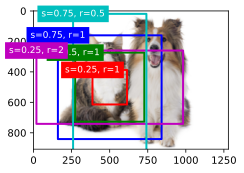

In [36]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[500, 500, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.25, r=2','s=0.75, r=0.5'])

In [38]:
"""交并比（IoU）"""
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    box_area = lambda boxes: (boxes[:, 2] - boxes[:, 0] *
                              boxes[:, 3] - boxes[:, 1])

    """
        boxes存储的格式为(xmin, ymin, xmax, yamx)，所以使得求取最小共有块的边时是取左边最大值，右边最小值，（图像y轴是越往下数值越大，x轴是越往右数值越大）
        boxes1, boxes2, area1, area2的形状：
            boxes1：(boxes1数量, 4)，
            boxes2：(boxes2数量, 4)，
            areas1：(area1数量, )，
            areas2：(area2数量, )
    """
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)

    """
        inter_upperlefts, inter_lowerrights, inters的形状：
            (boxes1的数量, boxes2的数量, 2)
    """
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)## clamp起限制数值使用，这里限制最小值为0，如果小于0，则设为0

    """
        inter_areasandunion_areas的形状：(boxes1的数量, boxes2的数量)
    """
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 -inter_areas
    return  inter_areas / union_areas

### 将真实边界框分配给锚框
给定图像，假设有锚框$A_1,A_2,...,A_{n_a}$，真实边界框是$B_1,B_2,...,B_{n_b}$，其中$n_a\geqslant n_b$。定义一个矩阵X，形状为$n_a \times n_b$，其中第i行第j列元素$x_{ij}$是锚框$A_i$和真实边界框$B_j$的IoU，算法步骤如下：
> * 在矩阵X中找到一个最大元素，并将它的行索引和列索引分别表示为$i1$和$j1$。让后将真实边界框$B_{j1}$分配给锚框$A_{i1}$。IoU值最大直观地表明了$A_{i1}$和$B_{j1}$是所有锚框中和真实边界框配对中最为相近的。在第一个锚框分配完成后，丢弃X矩阵中第$i1$行和第$j1$列中的所有元素；
> * 在矩阵X中找到剩下元素中最大的元素，并将他们的行索引和列索引分别用$i2$和$j2$表示。然后将真实边界框$B_{j2}$分配给锚框$A_{i2}$，丢弃矩阵中第$i2$行和第$j2$列中的所有元素；
> * 此时，矩阵中的两行两列元素应经被丢弃。继续之前的步骤，直到丢弃矩阵X中$n_b$列中的所有元素。此时已经为$n_b$个锚框各自分配了一个真实边界框；
> * 遍历剩下的$n_a-n_b$个锚框。例如，给定锚框$A_i$,在矩阵X的第i行中找到与$A_i$的IoU最大真实边界框$B_j$，只有当此IoU大于预定义的阈值时，才将$B_j$分配给$A_i$。

![](../images/Distribute-Anchor-Box.png)

<font color='red'>下列算法中将第四步放在了前面，然后再执行步骤1，2，3</font>

In [39]:
"""将真实边界框分配给锚框"""
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    """位于第i行和第j列的元素x_ij是锚框i和真实边界框j的ioU"""
    jaccard = box_iou(anchors, ground_truth)
    """对于每个锚框，分配真实边界框的张量"""
    anchors_bbox_map = torch.full((num_anchors, ), -1, dtype=torch.long, device=device)

    """
        torch.max(a,dim)的作用：
        设a为[[1, 4, 2, 3],
             [5, 2, 6, 3],
             [7, 1, 9, 3]]
        经过torch.max(a, dim=1)后输出两个值，分别是：
        最大值矩阵[[4],
                 [6],
                 [9]].形状为3*1矩阵
        最大值下标矩阵[[1],
                    [2],
                    [2]].形状为3*1矩阵
    """
    ## 根据阈值，决定是否分配真实边界框
    ## 这里max_ious表示每个锚框与各个真实边界框的最大交并比，获取的索引indices就是该锚框与第几个真实边界框有着最大交并比
    max_ious, indices = torch.max(jaccard, dim=1) ## torch.max()返回最大值和最大值索引，这里会根据维度获取最大值，故会返回多个最大值

    """torch.nonzero()会返回张量中不是0的元素的位置，对于判断条件即使符合条件的位置"""
    ## 这里anc_i存储的是max_iou中大于等于iou_threshold的位置，该位置为max_iou中的位置即第几个锚框
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)

    """indices[判定条件]应当是输出indices判定条件为真的元素"""
    ## 这里box_j存储的符合条件的锚框应属于哪一个真实边界框的预测
    box_j = indices[max_ious >= iou_threshold]

    ## 为每一个锚框都匹配一个真实边界框，前提是该锚框要与其中之一的真实边界框的交并比大于设定阈值，否则不进行分配
    anchors_bbox_map[anc_i] = box_j

    ## 这两行代码用于填充取完最大值之后行和列
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)

    """
        这里会对锚选框所对应的真实边界框进行更换，如下例：
        假设a[[7, 10],
              [8, 9]]
        经过上面的过程会得到b[[1],
                          [1]]
        但是经过下面过程后会变为b[[1],
                              [0]]
        个人感觉把下面的过程调在上面过程之前会好一点
        下面过程中没有做阈值判定，有几率将达不到阈值的锚选框添加进预测行列
    """
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard) ## 返回最大值的序列号，并不是行列式，而是从0到len（jaccard）之间的值
        box_idx = (max_idx % num_gt_boxes).long() ## 取得最大元素的列数，即该锚框属于哪一个真实边界框
        anc_idx = (max_idx / num_gt_boxes).long() ## 取得最大元素的行数，即第几个锚选框
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

### 偏移量
假设一个锚框A被分配了一个真实边界框B。一方面，锚框A的类别将被标记为与B相同。另一方面，锚框A的偏移量将根据B和A中心点坐标相对位置以及这两个框的相对大小进行标记。鉴于数据集内不同框的位置和大小不同，可以对那些相对位置和大小应用变换，使其获得分布更均匀且易于拟合的偏移量。以下介绍一种常见的变换：
> 给定框A和B，中心坐标分别为$(x_a,y_a)$和$(x_b,y_b)$，宽度分别为$w_a$和$w_b$，高度分别为$h_a$和$h_b$，可以将A的偏移量标记为：
>>  * $(\frac{\frac{x_b-x_a}{w_a}-\mu_x}{\sigma_x}, \frac{\frac{y_b-y_a}{h_a}-\mu_y}{\sigma_y}, \frac{log\frac{w_b}{w_a}-\mu_w}{\sigma_w}, \frac{log\frac{h_b}{h_a}-\mu_h}{\sigma_h})$
>>  * <font color='red'>常量的默认值为$\mu_x=\mu_y=\mu_w=\mu_h=0, \sigma_x=\sigma_y=0.1, \sigma_w=\sigma_h=0.2$</font>

In [40]:
"""标记类和偏移"""
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:]) / c_anc[:, 2:]
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [60]:
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device
        )
        ## 只要anchors_bbox_map中有大于等于0的值，说明该锚框大于IoU阈值，可以对某一边界框进行预测，故不是背景，按照anchors_bbox_map的格式符合条件的写入1，不符写0，然后在最后添加一个维度，行不变，列扩展4倍
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1).repeat(1, 4))

        """将类标签和分配的边界框坐标初始化为0"""
        class_labels = torch.zeros(num_anchors, dtype=torch.long, device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)

        """
            使用真实边界框来标记锚框的类别
            如果一个锚框没有被分配，标记其为背景（值为零）
        """
        ## 获取有效锚框的位置下标
        indices_true = torch.nonzero(anchors_bbox_map >= 0)

        ## 通过有效锚框的位置下标获取该锚框负责真实边界框的标号
        bb_idx = anchors_bbox_map[indices_true]

        ## class.labels中存储着锚框所预测类的序号，加1是因为背景的存在，0表示背景的存在
        class_labels[indices_true] = label[bb_idx, 0].long() + 1

        ## 获取对应下标的真实边界框位置信息
        assigned_bb[indices_true] = label[bb_idx, 1:]

        """偏移量转换"""
        ## 乘上bbox_mask是因为对于背景锚框就不要再去做偏移，浪费计算
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    """bbox_offset中存放着anchor到真实边界框的偏移量，bbox_mask表明给锚框是背景锚框还是有框中物体，背景锚框值为0，有物体为1，class_label表明该锚框所对应的类的名称"""
    return (bbox_offset, bbox_mask, class_labels)

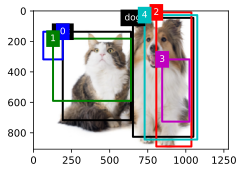

In [74]:
ground_truth = torch.tensor([[0, 0.15, 0.15, 0.5, 0.79],
                         [1, 0.51, 0.05, 0.82, 0.91]])
anchors = torch.tensor([[0.15, 0.15, 0.05, 0.35], [0.1, 0.2, 0.5, 0.65],
                   [0.63, 0.01, 0.81, 0.98], [0.66, 0.35, 0.8, 0.8],
                   [0.57, 0.03, 0.84, 0.93]])

#下面的例子会将小于阈值也添加进训练过程中
# anchors = torch.tensor([[0.15, 0.15, 0.05, 0.35], [0.2, 0.3, 0.5, 0.5],
#                    [0.63, 0.01, 0.81, 0.98], [0.66, 0.35, 0.8, 0.8],
#                    [0.57, 0.03, 0.84, 0.93]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['cat', 'dog'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [75]:
# A = torch.tensor([[1, 4, 2, 3],
#                   [5, 2, 6, 3],
#                   [7, 1, 4, 9]])
# max_a, index = torch.max(A, dim=1)
#
# anc_i = torch.nonzero(max_a >= 5).reshape(-1)
#
# box_j = index[max_a >= 5]
#
# [max_a>=5], max_a, index, anc_i, box_j

In [76]:
labels = multibox_target(anchors.unsqueeze(dim=0), ground_truth.unsqueeze(dim=0))

max_ious:
tensor([0.00, 0.51, 0.46, 0.38, 0.58])
indices:
tensor([0, 0, 1, 1, 1])
anc_i:
tensor([1, 4])
box_j:
tensor([0, 1])
anchors_bbox_map:
tensor([-1,  0, -1, -1,  1])


In [77]:
labels[2]

tensor([[0, 1, 0, 0, 2]])

In [78]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [79]:
labels[0]

tensor([[ 0.00e+00, -0.00e+00,  0.00e+00, -0.00e+00,  6.25e-01,  1.00e+00,
         -1.31e+01, -4.96e+00, -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -1.48e+00,  3.31e-07,
         -2.17e+01, -8.38e-01]])

In [80]:
"""应用逆偏移变换来返回预测的边界框坐标"""
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, 2:] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predict_bbox = d2l.box_center_to_corner(pred_bbox)
    return predict_bbox

### 非极大值抑制（non-maximum suppression，NMS）
对于一个预测边界框B，目标检测模型会计算每个类别的预测概率。假设最大的预测概率为p，则该概率所对应的类别B就是预测的类别。具体来说就是将p称为预测边界框的置信度(confidence)。在同一张图像中，所有预测的非背景边界框都按置信度降序排序，以生成列表L。使用如下步骤操作排序列表L：
> * 从L中选取置信度最高的预测边界框$B_1$作为基准，然后将所有与$B_1$的IoU超过阈值$\epsilon$的非基准预测边界框从L中移除。这时，L保留了置信度最高的预测边界框，去除了与其太过相似的其他预测边界框。简而言之，那些具有非极大值置信度的边界框被抑制了。<font color='red'>（这里保留下来的是与当前锚框低耦合度的锚框，因为他们可能和当前锚框框中的并不是同一个物体，耦合度高只保留置信度高的锚选框，耦合度低的全部保留）</font>
> * 从L中选取置信度第二高的预测边框$B_2$作为一个基准，然后将所有与$B_2$的IoU大于$\epsilon$的非基准预测边界框从L中移除
> * 重复上述过程，直到L中的所有预测边界框都曾被用作基准。此时，L中任意一堆预测边界框的IoU都小于阈值$\epsilon$；因此，没有一对边界框过于相似
> * 输出列表L中所有预测边界框

In [106]:
"""以下nms函数按降序对置信度进行排序并返回其索引"""
"""scores有几列就对应着有几个锚框"""
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""

    """
        torch.argsort()会返回按dim维度进行排序，返回排序后的下标信息，descending控制是否降序例如:
        输入a[[2, 0, 1, 3],
            [5, 7, 10, 11],
            [9, 4, 6, 8]]
        经过torch.argsort(a, dim=-1, descending=True)会进行降序排序
        输出[[3, 0, 2, 1],
            [3, 2, 1, 0],
            [0, 3, 2, 1]]
        torch.sort()会返回排序的值和下标信息
    """
    ## 这里的scores是1xn的格式，scores存储的是锚框所能对应的最大置信度信息，scores是一维信息,
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = [] ## 保留预测边界框的指标，keep中存储的是可用于预测的锚框的下标
    while B.numel() > 0:
        ## 获得最大置信度的下标信息
        i = B[0]
        keep.append(i)
        if B.numel() == 1:break

        ## 求当前最大置信度锚框其他锚框之间的IoU
        ## iou的是一维向量，长度为len(B[1:])，
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        ## 获取满足条件的下标，即iou值小于阈值的锚框下标，满足该条件的锚框极有可能和当前锚框框中的并不是同一个物体，所以需要保留
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        ## 因为上述iou返回的坐标位置没有考虑最大置信度锚框这一列，即返回的列数为len(B[1:])， 缺少B[0]列，所以下标位置需要加1
        """
            X = X[x+1]的用法如下,该计算仅限于张量中：
            设X=[1, 2, 3, 4, 5], x=[0, 1, 3]
            则经过X = X[x+1]计算后：
            X = [2, 3, 5]
        """
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

# X = torch.tensor([[2, 0, 1, 3],
#                   [5, 7, 10, 11],
#                   [9, 4, 6, 8]])
# Y = torch.sort(X, dim=-1)
# Z = torch.argsort(X, dim=-1, descending=True)
# M = torch.tensor([2, 5, 7])
# N = torch.argsort(M , dim=-1, descending=True)
# A = X[N[0], :]
# B = X[N[1:], :]
# Y, Z, N, A, B, N[1:]
#
# X=[1, 2, 3, 4, 5]
# x=[0, 1, 3]
# X = torch.tensor(X)
# x = torch.tensor(x)
# X=X[x+1]
# X

In [111]:
"""将非极大值抑制应用于预测边界框"""
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用极大值抑制来预测边界框"""
    ## cls_probs存储着每个锚框对于每个类别的置信度信息，形状为（batch_size，类别+1， 锚框数）加1是因为有背景类
    ## offset_pred是预测锚框的偏移量
    ## anchors是预测的锚框
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
       cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)

       """
            假设cls_prod=[[0, 0.9, 0.1, 0],
                          [0.9, 0.4, 0.3, 0.2],
                          [0.3, 0.2, 0.1, 0.8]]
            则torch.max(cls_prod,dim=0)后返回
            conf=[0.9, 0.9, 0.3, 0.8], class_id=[1, 0, 1, 2]
            这两组信息组合表示每个锚框对应预测的类别（class_id）以及预测的置信度（conf）
       """
       ## 通过torch.max()获取cls_probs每个锚框所能预测置信度最高的是哪个类，返回置信度信息和类别信息
       conf, class_id = torch.max(cls_prob[1:], 0)
       predicted_bb = offset_inverse(anchors, offset_pred)
       keep = nms(predicted_bb, conf, nms_threshold)

       """找到所有non_keep索引，并将类设置为背景"""
       all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
       combined = torch.cat((keep, all_idx))

       """
           unique()：返回参数数组中所有不同的值，并按照从小到大排序
           可选参数：
           return_index=True，返回新列表中的每个元素在原列表中第一次出现的索引值，因此元素个数与新列表中元素个数一样(numpy中有此操作，张量中没有该操作)
           return_inverse=True，返回原列表的每个元素在新列表中出现的索引值，因此元素个数与原列表中元素个数一样
           return_counts=True，返回新列表中每个元素在原列表中出现的次数，因此元素个数与新列表中元素个数一样
           有列表A[1, 2, 2, 1, 5]
           则经过A.unique()返回一个列表[1, 2, 5]
           经过A.unique(return_index=True)返回两个列表，分别是[1, 2, 5]和[0, 1, 4]
           经过A.unique(return_inverse=True)返回两个列表，分别是[1, 2, 5]和[0, 1, 1, 0, 2]
           经过A.unique(return_counts=True)返回两个列表，分别是[1, 2, 5]和[2, 2, 1]
       """
       uniques, counts = combined.unique(return_counts=True)
       # 如果锚框仅仅出现一次，则表明在非最大值抑制过程中，该锚框被抛弃了，non_keep存储着被抛弃的锚框的下标
       non_keep = uniques[counts == 1]
       all_id_sorted = torch.cat((keep, non_keep))
       # 将背景类的类别信息置为-1
       class_id[non_keep] = -1
       class_id = class_id[all_id_sorted]
       conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]

       """pos_threshold是一个用于非背景预测的阈值"""
       below_min_idx = (conf < pos_threshold)
       # 将置信度低于某个阈值的锚框预测类别设为背景，并将该锚框对于背景的预测置信度设为1-原置信度
       class_id[below_min_idx] = -1
       conf[below_min_idx] = 1 - conf[below_min_idx]
       pred_info = torch.cat((class_id.unsqueeze(1),conf.unsqueeze(1),predicted_bb), dim=1)
       out.append(pred_info)
    return  torch.stack(out)

In [129]:
anchors = torch.tensor([[0.15, 0.15, 0.05, 0.35], [0.1, 0.2, 0.5, 0.65],
                   [0.63, 0.01, 0.81, 0.98], [0.66, 0.35, 0.8, 0.8],
                   [0.57, 0.03, 0.84, 0.93]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0.9, 0, 0, 0, 0],
                          [0, 0.75, 0.2, 0.2, 0.1],
                          [0, 0.5, 0.6, 0.4, 0.8]])

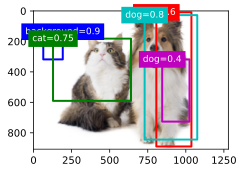

In [130]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors*bbox_scale,
            ['background=0.9', 'cat=0.75', 'dog=0.6', 'dog=0.4', 'dog=0.8'])

In [131]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 1.00,  0.80,  0.57,  0.03,  0.84,  0.93],
         [ 0.00,  0.75,  0.10,  0.20,  0.50,  0.65],
         [ 1.00,  0.40,  0.66,  0.35,  0.80,  0.80],
         [-1.00,  1.00,  0.15,  0.15,  0.05,  0.35],
         [-1.00,  0.60,  0.63,  0.01,  0.81,  0.98]]])

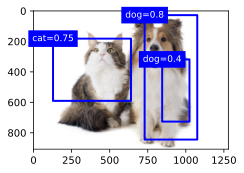

In [132]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('cat=', 'dog=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

置信度为0.4可以被保留是因为它与置信度0.8的锚框的IoU小于阈值0.5，所以得到了保留。